<a href="https://colab.research.google.com/github/tianfa-lee/Housing-Price-Prediction/blob/main/Housing%20Price%20Prediction%20(Neural%20Network).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.2.2)


In [ ]:
# Import training and testing dataset from Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import category_encoders as ce

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
# Change directory to the one containing the datasets
os.chdir("/content/gdrive/My Drive/EE4483 Assignment/Option 1/data")

# Load training dataset and remove Id 
train_input = pd.read_csv('./train.csv')
train_input.pop('Id')

# Inspect the training dataset 
train_input.describe()

,OverallQual,GrLivArea,GarageArea,SalePrice
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.125000,1510.493000,473.350000,182284.451000
std,1.383217,512.296179,208.901597,80291.215207
min,1.000000,334.000000,0.000000,34900.000000
25%,5.000000,1125.750000,338.000000,130000.000000
50%,6.000000,1456.000000,480.000000,163995.000000
75%,7.000000,1774.250000,576.000000,215000.000000
max,10.000000,4676.000000,1390.000000,755000.000000


In [ ]:
# Check for null values in the training dataset and remove them if there is any.
train_input.isnull().values.any()

False

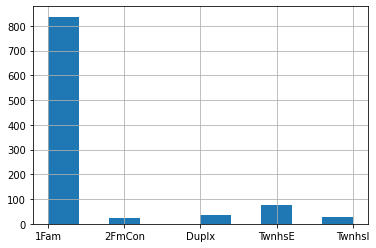

In [ ]:
# Inspect the type and the number of categories in "BldgType" attribute of the training dataset.
train_input.BldgType.hist()

In [ ]:
# Convert BldgType into one-shot vector of length 5
encoder = ce.OneHotEncoder(use_cat_names=True)
train = encoder.fit_transform(train_input)
train.tail()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,BldgType_1Fam,BldgType_2FmCon,BldgType_Duplx,BldgType_TwnhsE,BldgType_TwnhsI,OverallQual,GrLivArea,GarageArea,SalePrice
995,1,0,0,0,0,4,1230,305,121600
996,1,0,0,0,0,5,1050,368,136500
997,1,0,0,0,0,6,1442,615,185000
998,1,0,0,0,0,3,1077,210,91000
999,1,0,0,0,0,7,1208,632,206000


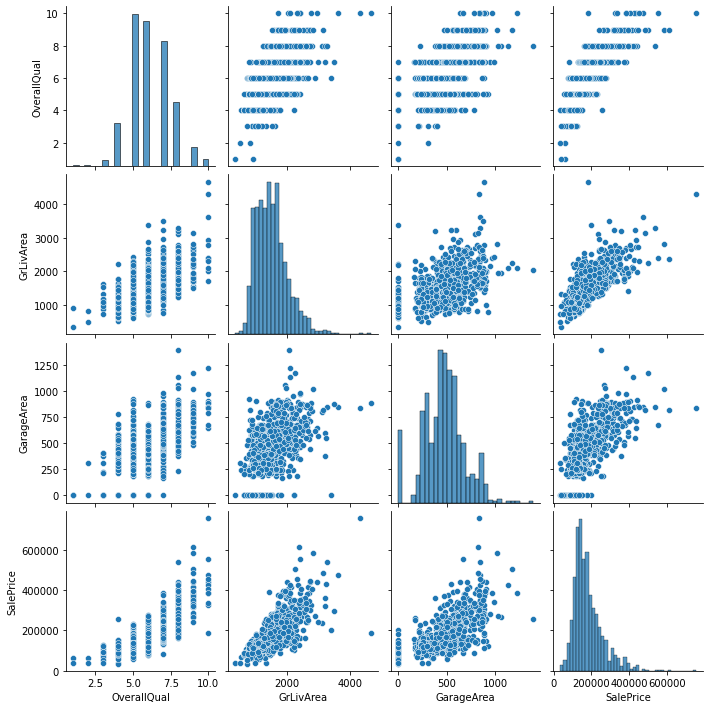

In [ ]:
# Create a pairplot to identify any trends in the dataset
sns.pairplot(train[["OverallQual", "GrLivArea", "GarageArea", "SalePrice"]])

In [ ]:
# Split training dataset into x_train and y_train where x_train is the input variables of data attributes excluding "SalePrice" and 
# y_train is the "SalePrice" attribute (i.e output variable that we want to predict)

x_train = train.sample(frac=1, random_state=0)
y_train = x_train.pop('SalePrice')

In [ ]:
# Create another table for the purpose of data normalization later

train_details = x_train.describe()
train_details = train_details.transpose()
train_details

,count,mean,std,min,25%,50%,75%,max
BldgType_1Fam,1000.0,0.837,0.369550,0.0,1.00,1.0,1.00,1.0
BldgType_2FmCon,1000.0,0.023,0.149978,0.0,0.00,0.0,0.00,1.0
BldgType_Duplx,1000.0,0.036,0.186383,0.0,0.00,0.0,0.00,1.0
BldgType_TwnhsE,1000.0,0.075,0.263523,0.0,0.00,0.0,0.00,1.0
BldgType_TwnhsI,1000.0,0.029,0.167890,0.0,0.00,0.0,0.00,1.0
OverallQual,1000.0,6.125,1.383217,1.0,5.00,6.0,7.00,10.0
GrLivArea,1000.0,1510.493,512.296179,334.0,1125.75,1456.0,1774.25,4676.0
GarageArea,1000.0,473.350,208.901597,0.0,338.00,480.0,576.00,1390.0


In [ ]:
# Z-score Normalization: x' = (x - μ) / σ	

def norm(x):
    return (x - train_details['mean']) / (train_details['std'])
normed_x_train = norm(x_train)

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_33 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 129       
Total params: 17,345
Trainable params: 17,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

Epoch = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)



history = model.fit(
  normed_x_train, y_train,
  epochs=Epoch, validation_split=0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


....................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
79,1.386068e+09,24303.867188,1.386068e+09,849395776.0,19804.980469,849395776.0,79
80,1.371674e+09,24156.789062,1.371674e+09,880230144.0,20304.917969,880230144.0,80
81,1.381569e+09,24277.216797,1.381569e+09,906329280.0,20768.876953,906329280.0,81
82,1.388895e+09,24216.619141,1.388895e+09,832939712.0,19542.037109,832939712.0,82
83,1.380877e+09,24008.490234,1.380877e+09,867354688.0,20133.632812,867354688.0,83


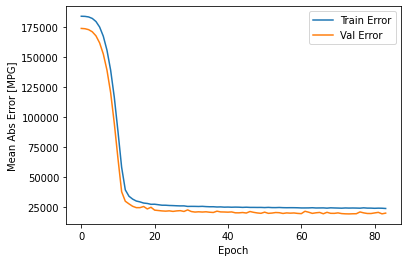

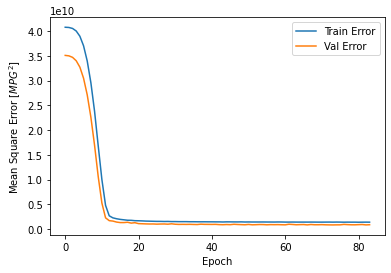

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')

    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    plt.show()


plot_history(history)

In [ ]:
newdata = train
new_label = newdata.pop('SalePrice')
normed_train = norm(newdata)

new_predict = model.predict(normed_train)
new_predict = new_predict.astype(int)

# Table displaying Actual and Prediction housing prices

df = pd.DataFrame({'Actual': new_label, 'Predicted': new_predict.flatten()})
df

,Actual,Predicted
0,208500,217656
1,181500,154559
2,223500,228460
3,140000,228118
4,250000,324693
...,...,...
995,121600,113065
996,136500,123847
997,185000,176826
998,91000,96679


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

print('Mean Squared Error: {}'.format(mean_squared_error(df.Actual, df.Predicted)))

print('R2 Score: {}'.format(r2_score(df.Actual, df.Predicted)))

Mean Squared Error: 1261787133.755
R2 Score: 0.8040773959703132


In [ ]:
# Load the testing dataset and remove Id
test_input = pd.read_csv('./test.csv')
id_col = test_input.pop('Id')

# Inspect the testing dataset
test_input.describe()

,OverallQual,GrLivArea,GarageArea
count,259.000000,259.000000,259.000000
mean,6.081081,1548.030888,475.467181
std,1.379947,560.911287,219.228602
min,3.000000,630.000000,0.000000
25%,5.000000,1148.000000,336.000000
50%,6.000000,1513.000000,484.000000
75%,7.000000,1844.000000,574.000000
max,10.000000,5642.000000,1418.000000


In [ ]:
# Check for null values in the testing dataset and remove them if there is any.
test_input.isnull().values.any()

False

In [ ]:
# Insert predicted SalePrice into "submission.csv" and save the file
encode_input = encoder.fit_transform(test_input)
normed_test_input = norm(encode_input)
test_predict = model.predict(normed_test_input)
test_predict = test_predict.astype(int)

# Insert predicted SalePrice into test dataset
test_input.insert(4, 'SalePrice', test_predict.flatten())

# Insert predicted SalePrice into submission file
df_test_result = pd.DataFrame({'Id': id_col, 'SalePrice': test_predict.flatten()})
df_test_result

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Id,SalePrice
0,1202,214209
1,1203,122948
2,1204,185754
3,1205,143036
4,1206,279348
...,...,...
254,1456,174864
255,1457,206324
256,1458,192561
257,1459,116288


In [ ]:
# Save the file with the predicted SalePrice
df_test_result.to_csv(r'./submission.csv', index=None)

In [ ]:
# Query the test set result for SalePrice > 250 000 and find the total number
SalePrice_above250000 = test_input.query('SalePrice>250000')
print('Number of Houses with SalePrice > 250 000 = {}'.format(len(SalePrice_above250000)))
SalePrice_above250000

Number of Houses with SalePrice > 250 000 = 41


,BldgType,OverallQual,GrLivArea,GarageArea,SalePrice
4,1Fam,7,2196,701,279348
27,TwnhsE,9,1702,1052,335026
40,1Fam,7,1689,954,316512
42,1Fam,10,2076,850,371704
55,1Fam,8,1987,691,280171
66,1Fam,9,2018,746,317793
67,1Fam,8,3447,1014,481001
77,1Fam,8,2031,577,252328
88,1Fam,8,1970,753,297099
97,1Fam,10,5642,1418,798243


In [ ]:
# Query the test set result for GarageArea > 700 and find the total number

GarageArea_above700 = SalePrice_above250000.query('GarageArea>700')
print('Number of Houses with GarageArea > 700 = {}'.format(len(GarageArea_above700)))
GarageArea_above700

Number of Houses with GarageArea > 700 = 30


,BldgType,OverallQual,GrLivArea,GarageArea,SalePrice
4,1Fam,7,2196,701,279348
27,TwnhsE,9,1702,1052,335026
40,1Fam,7,1689,954,316512
42,1Fam,10,2076,850,371704
66,1Fam,9,2018,746,317793
67,1Fam,8,3447,1014,481001
88,1Fam,8,1970,753,297099
97,1Fam,10,5642,1418,798243
101,1Fam,8,2526,844,364131
102,1Fam,7,1616,834,276077


In [ ]:
# Query the test set result for GrLivArea > 2000 and find the total number

GrLiveArea_above2000 = SalePrice_above250000.query('GrLivArea>2000')
print('Number of Houses with GrLivArea > 2000 = {}'.format(len(GrLiveArea_above2000)))
GrLiveArea_above2000

Number of Houses with GrLivArea > 2000 = 20


,BldgType,OverallQual,GrLivArea,GarageArea,SalePrice
4,1Fam,7,2196,701,279348
42,1Fam,10,2076,850,371704
66,1Fam,9,2018,746,317793
67,1Fam,8,3447,1014,481001
77,1Fam,8,2031,577,252328
97,1Fam,10,5642,1418,798243
101,1Fam,8,2526,844,364131
111,1Fam,8,2810,750,357117
112,1Fam,9,2599,779,369498
127,1Fam,6,2792,520,257757


In [ ]:
# Query the test set result for OverallQual > 8 and find the total number  
OverallQual_above8 = SalePrice_above250000.query('OverallQual>8')
print('Number of Houses with OverallQual > 8 = {}'.format(len(OverallQual_above8)))
OverallQual_above8

Number of Houses with OverallQual > 8 = 10


,BldgType,OverallQual,GrLivArea,GarageArea,SalePrice
27,TwnhsE,9,1702,1052,335026
42,1Fam,10,2076,850,371704
66,1Fam,9,2018,746,317793
97,1Fam,10,5642,1418,798243
104,1Fam,9,1652,840,318966
112,1Fam,9,2599,779,369498
158,1Fam,9,1980,770,322084
172,1Fam,10,2633,804,398495
187,1Fam,9,1746,758,301766
241,1Fam,10,2007,812,355612
